In [1]:
import csv
import math
import sys, time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import *

True


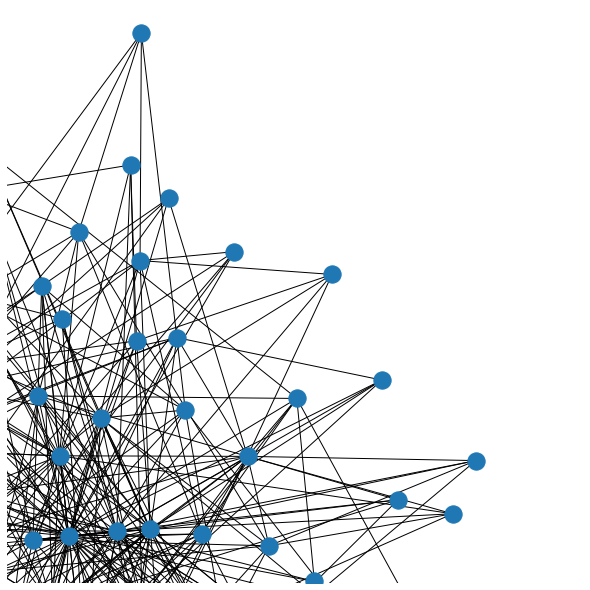

{(10, 95), (72, 95), (21, 95), (87, 95), (52, 95)}


In [3]:
# Use seed when creating the graph for reproducibility
G1 = nx.barabasi_albert_graph(100, 5)

print(nx.is_connected(G1))

if nx.is_connected(G1)==False:
    largest_cc = max(nx.connected_components(G1), key=len)
    G = G1.subgraph(largest_cc).copy() 
else:
    G = G1.copy()


# position is stored as node attribute data for random_geometric_graph
# pos = nx.get_node_attributes(G, "pos")

# print(pos)

# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
# for n in pos:
#     x, y = pos[n]
#     d = (x - 0.5) ** 2 + (y - 0.5) ** 2
#     if d < dmin:
#         ncenter = n
#         dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(G, ncenter))

plt.figure(figsize=(8, 8))
# nx.draw_networkx_edges(G, alpha=0.4)
# nx.draw_networkx_nodes(
#     G,
#     nodelist=list(p.keys()),
#     node_size=80,
#     node_color=list(p.values()),
#     cmap=plt.cm.Reds_r,
# )

nx.draw(G)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()


site = {}

for node in G.nodes():
    site[node] = str(node)

for (u,v) in G.edges():
    if (u>v):
        u, v = v, u
    G.add_edge(u,v)
    G[u][v]['capa'] = np.random.random()*0.5 + 0.5 

n_demand = 25
K = nx.DiGraph()


for k in range(n_demand):
    nodeA = np.random.randint(200)
    while nodeA not in G.nodes():
        nodeA = np.random.randint(200)

    nodeB = np.random.randint(200)
    while nodeA == nodeB or nodeB not in G.nodes() :
        nodeB = np.random.randint(200)
        
    if nodeA > nodeB:
        tmp = nodeA
        nodeA = nodeB
        nodeB = tmp
        
    K.add_edge(nodeA,nodeB)                    
    # K[nodeA][nodeB]['demand'] = float(row['demand'])/25.0 #Pour arriver à des taux de charges raisonnables
    K[nodeA][nodeB]['demand'] = np.random.uniform(0,1)
    # print(float(row['demand'])

print(nx.minimum_edge_cut(G))



In [ ]:
# G = nx.Graph()
# pos = {}
# site = {}

# # with open('nodes_cost266.csv', 'r') as f_node:
# # with open('nodes_cost_2_commodity.csv', 'r') as f_node:
# with open('w_node.csv', 'r') as f_node:
#     reader = csv.DictReader(f_node, delimiter=';', quotechar="'")
#     for row in reader:
#         node = int(row['node'])
#         site_node = row['site']
#         x_coord = float(row['X'])
#         y_coord = float(row['Y'])
#         G.add_node(node,site=site_node)
#         pos[node] = [x_coord,y_coord]
#         site[node] = site_node

In [ ]:
# # with open('edges_cost266.csv', 'r') as f_edge:
# # with open('edges_cost_2_commodity.csv', 'r') as f_edge:
# with open('w_edge.csv', 'r') as f_edge:
#     reader = csv.DictReader(f_edge, delimiter=';', quotechar="'")
#     for row in reader:
#         nodeA = int(row['nodeA'])
#         nodeB = int(row['nodeB'])
#         G.add_edge(nodeA,nodeB)        
#         G[nodeA][nodeB]['capa'] = float(row['capa'])

In [4]:
H = nx.DiGraph(G)
capa = {}

for (u,v) in G.edges():
    capa[(u,v)] = G[u][v]['capa']
    capa[(v,u)] = G[u][v]['capa']

In [ ]:
# K = nx.DiGraph()

# # with open('demand_cost266.csv', 'r') as f_demand:
# # with open('demand_2_commodity.csv', 'r') as f_demand:
# with open('w_demand.csv', 'r') as f_demand:
#     reader = csv.DictReader(f_demand, delimiter=';', quotechar="'")
#     for row in reader:
#         nodeA = int(row['nodeA'])
#         nodeB = int(row['nodeB'])
#         if nodeA > nodeB:
#             tmp = nodeA
#             nodeA = nodeB
#             nodeB = tmp
            
#         K.add_edge(nodeA,nodeB)                    
#         # K[nodeA][nodeB]['demand'] = float(row['demand'])/25.0 #Pour arriver à des taux de charges raisonnables
#         K[nodeA][nodeB]['demand'] = float(row['demand'])
#         # print(float(row['demand']))

In [5]:
print(len(G.nodes()),'nodes')
print(len(G.edges()),'edges')
print(len(K.edges()),'demands')

100 nodes
475 edges
25 demands


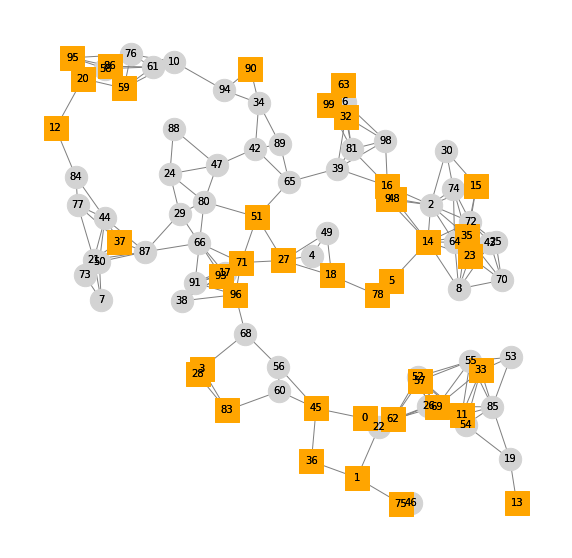

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,10));
plt.axis('off')

nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')

nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color='grey')

nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')

In [6]:
# +++ Flow Conservation constraints +++
def flowConservation(model, node, o, d):
    inFlow = sum(
        model.flow[i, j, o, d]
        for (i, j) in model.arcs
        if j == node
    )
    outFlow = sum(
        model.flow[i, j, o, d]
        for (i, j) in model.arcs
        if i == node
    )
    if node == o:
        return (inFlow - outFlow + K[o][d]['demand'] == 0)
    elif node == d:
        return (inFlow - outFlow - K[o][d]['demand'] == 0)
    else:
        return (inFlow == outFlow)


In [7]:
#+++ Capacity constraints +++
def linkCapacity(model, i, j):
    expression = sum(model.flow[i,j,o,d] + model.flow[j,i,o,d] for (o,d) in model.demands)<= model.capa[i,j] * model.gamma
    return expression

In [8]:
solver = 'cplex'

print('>>> Loading optimization model')

model = ConcreteModel()

model.dual = Suffix(direction=Suffix.IMPORT)

model.nodes   = H.nodes()
model.links   = G.edges()
model.arcs    = H.edges()
model.demands = K.edges()

model.index1 = Set(initialize=[(u, o, d) for u in model.nodes for (o, d) in model.demands])
model.index2 = Set(initialize=[(u, v, o, d) for (u, v) in model.arcs for (o, d) in model.demands])

model.capa = Param(model.arcs, initialize=capa)

model.flow  = Var(model.index2, domain=NonNegativeReals)
model.gamma = Var(domain=NonNegativeReals)

model.objective = Objective(rule=lambda m: m.gamma, sense=minimize)

model.flowConserv = Constraint(model.index1, rule=flowConservation)

model.linkCapa = Constraint(model.links, rule=linkCapacity)


>>> Loading optimization model


In [9]:
print('>>> Solving optimization model')
    
# model.preprocess()

optim = SolverFactory(solver)
    
start_time = time.time()

results = optim.solve(model)
    
cpu_time = time.time() - start_time

print('+ TERM STAT:',results.solver.status)
print('+ TERM COND:',results.solver.termination_condition)
    
print('+ CPU  TIME = {0:.2f} s'.format(cpu_time))

if results.solver.status == SolverStatus.ok and results.solver.termination_condition != TerminationCondition.infeasible:
    print('+ OPT VAL  = {0:.8f}'.format(model.gamma.value))
    print('+ LWR BND  = {0:.2f}'.format(results.Problem._list[0]['Lower bound']))

>>> Solving optimization model
+ TERM STAT: ok
+ TERM COND: optimal
+ CPU  TIME = 2.57 s
+ OPT VAL  = 0.43269987
+ LWR BND  = 0.43


In [10]:
epsilon = 1.0e-06

load = {}
    
for (u,v) in G.edges():
    TotalFlow = 0.0
    for (o,d) in K.edges():
        TotalFlow += model.flow[u,v,o,d].value  #On somme pour chaque lien le flow qui passe
        TotalFlow += model.flow[v,u,o,d].value
    G[u][v]['flow'] = TotalFlow    
    if TotalFlow > epsilon:
        load[(u,v)] = 100*TotalFlow/model.capa[(u,v)]
        # print(load[(u,v)])
        print('link ({0:10s},{1:10s}):\tflow = {2:8f} / capacity = {3:8f} -> load = {4:.2f} %'.format(site[u],site[v],TotalFlow,model.capa[(u,v)],load[(u,v)]))
        #print('link ({0:10s},{1:10s}):\tflow = {2:8f} / capacity = {3:8f} -> load = {4:.2f} %'.format(site[u],site[v],TotalFlow,model.capa[(u,v)],100*TotalFlow/model.capa[(u,v)]))
    else:
        load[(u,v)] = 0.0

link (0         ,1         ):	flow = 0.392362 / capacity = 0.906776 -> load = 43.27 %
link (0         ,2         ):	flow = 0.124582 / capacity = 0.897806 -> load = 13.88 %
link (0         ,3         ):	flow = 0.356890 / capacity = 0.824798 -> load = 43.27 %
link (0         ,4         ):	flow = 0.371688 / capacity = 0.858997 -> load = 43.27 %
link (0         ,5         ):	flow = 0.262317 / capacity = 0.606232 -> load = 43.27 %
link (0         ,6         ):	flow = 0.314732 / capacity = 0.727368 -> load = 43.27 %
link (0         ,7         ):	flow = 0.424821 / capacity = 0.981792 -> load = 43.27 %
link (0         ,8         ):	flow = 0.428834 / capacity = 0.991065 -> load = 43.27 %
link (0         ,9         ):	flow = 0.306743 / capacity = 0.708905 -> load = 43.27 %
link (0         ,10        ):	flow = 0.275607 / capacity = 0.636947 -> load = 43.27 %
link (0         ,11        ):	flow = 0.293178 / capacity = 0.794122 -> load = 36.92 %
link (0         ,12        ):	flow = 0.411747 / capaci

In [11]:
model.gamma.value
load1 = {}
G1 = G.copy()
Saturated_edge = []

print('____ Saturated Edges _____ ' )
for (u,v) in G1.edges():
    TotalFlow1 = 0.0
    for (o,d) in K.edges():
        TotalFlow1 += model.flow[u,v,o,d].value  #On somme pour chaque lien le flow qui passe
        TotalFlow1 += model.flow[v,u,o,d].value
    G1[u][v]['flow'] = TotalFlow1    
    if abs(100*TotalFlow1/model.capa[(u,v)] - model.gamma.value*100) < epsilon:
        Saturated_edge.append((u,v))
        load1[(u,v)] = 100*TotalFlow1/model.capa[(u,v)]
        print('link ({0:10s}, {1:10s}):\tflow = {2:8f} / capacity = {3:8f} -> load = {4:.2f} %'.format(site[u],site[v],TotalFlow1,model.capa[(u,v)],load1[(u,v)]))
        # model.capa[(u,v)] *= 0.9

# print(Saturated_edge)
def isSaturated(uv):
    isAttained = np.zeros(np.max(G.edges)+1)
    queue = collections.deque()
    u = uv[0]
    v = uv[1]
    isAttained[u] = 1
    for n in G.neighbors(u) : 
        if n not in queue and  abs(load[min(u,n), max(u,n)]  - model.gamma.value*100) > epsilon:
            queue.append(n)
    # for n in G.neighbors(u):
    #     if n not in queue:
    #         queue.append(n)
    while isAttained[v] == 0 and len(queue) != 0:
        n = queue.popleft()
        isAttained[n] = 1
        for n1 in G.neighbors(n) :
            if (n1 not in queue) and (isAttained[n1] == 0) and abs(load[min(n,n1), max(n,n1)]  - model.gamma.value*100) > epsilon:
                queue.append(n1)
    return isAttained[v] == 0 

critical_edge = []
for uv in Saturated_edge : 
    # print(isSaturated(uv))
    if isSaturated(uv):
        critical_edge.append(uv)
print('')
print('_____ Critical Edges ____')
for (u,v) in critical_edge:
    print('link ({0:10s}, {1:10s})\t'.format(site[u],site[v]),'site 1 = '+ str(u)+ ', site 2 = ' + str(v))
# print([site[critical_edge[k][0]] + ' -> ' + site[critical_edge[k][1]] for k in range(len(critical_edge))])


____ Saturated Edges _____ 
link (0         , 1         ):	flow = 0.392362 / capacity = 0.906776 -> load = 43.27 %
link (0         , 3         ):	flow = 0.356890 / capacity = 0.824798 -> load = 43.27 %
link (0         , 4         ):	flow = 0.371688 / capacity = 0.858997 -> load = 43.27 %
link (0         , 5         ):	flow = 0.262317 / capacity = 0.606232 -> load = 43.27 %
link (0         , 6         ):	flow = 0.314732 / capacity = 0.727368 -> load = 43.27 %
link (0         , 7         ):	flow = 0.424821 / capacity = 0.981792 -> load = 43.27 %
link (0         , 8         ):	flow = 0.428834 / capacity = 0.991065 -> load = 43.27 %
link (0         , 9         ):	flow = 0.306743 / capacity = 0.708905 -> load = 43.27 %
link (0         , 10        ):	flow = 0.275607 / capacity = 0.636947 -> load = 43.27 %
link (0         , 12        ):	flow = 0.411747 / capacity = 0.951577 -> load = 43.27 %
link (0         , 14        ):	flow = 0.320541 / capacity = 0.740793 -> load = 43.27 %
link (0        

In [12]:
for (o,d) in K.edges():
    print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']*model.gamma.value))
    # print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']))
    for (u,v) in model.arcs:
        if model.flow[u,v,o,d].value > epsilon:
            # print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value/model.gamma.value))
            print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value))


demand (42,96): 0.094234
	arc (0,44): flow = 0.065550
	arc (0,92): flow = 0.141808
	arc (1,0): flow = 0.128907
	arc (1,11): flow = 0.010423
	arc (1,32): flow = 0.078451
	arc (6,96): flow = 0.217781
	arc (7,16): flow = 0.065550
	arc (11,6): flow = 0.010423
	arc (16,34): flow = 0.065550
	arc (32,0): flow = 0.078451
	arc (34,6): flow = 0.207358
	arc (42,75): flow = 0.217781
	arc (44,7): flow = 0.065550
	arc (75,1): flow = 0.217781
	arc (92,34): flow = 0.141808
demand (42,58): 0.281063
	arc (0,24): flow = 0.252731
	arc (0,89): flow = 0.151797
	arc (3,58): flow = 0.000124
	arc (3,67): flow = 0.081558
	arc (6,62): flow = 0.133257
	arc (6,99): flow = 0.073083
	arc (9,0): flow = 0.102911
	arc (9,24): flow = 0.133893
	arc (9,31): flow = 0.013986
	arc (9,43): flow = 0.024065
	arc (11,0): flow = 0.168360
	arc (24,3): flow = 0.081682
	arc (24,27): flow = 0.318929
	arc (27,58): flow = 0.318929
	arc (31,24): flow = 0.013986
	arc (36,11): flow = 0.168360
	arc (42,9): flow = 0.274855
	arc (42,36): flo

In [13]:
criticalSources = []
criticalDemands = []

def getCriticalSources():
    # criticalSource = []
    criticalNodes = []
    criticalDemand = []
    # criticalDestination = []
    for (o,d) in K.edges():
        # print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']*model.gamma.value))
        # print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']))
        bool = False
        for (u,v) in model.arcs:
            if (min(u,v), max(u,v)) in critical_edge and model.flow[u,v,o,d].value > epsilon:
                # print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value/model.gamma.value))
                # print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value))
                bool = True
        if (bool):
            criticalDemand.append((o,d))
            if o not in criticalNodes :
                criticalNodes.append(o)
            if d not in criticalNodes:
                criticalNodes.append(d)
    return criticalDemand, criticalNodes

criticalDemands, criticalNodes= getCriticalSources()

print(criticalNodes)


print('_____ Critical Demands _____')
for (o,d) in criticalDemands : 
    print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']))



[42, 58, 53, 77, 2, 72, 99, 5, 36]
_____ Critical Demands _____
demand (42,58): 0.649556
demand (53,77): 0.759543
demand (2,77): 0.142967
demand (72,99): 0.912898
demand (5,77): 0.772550
demand (36,99): 0.619260


3


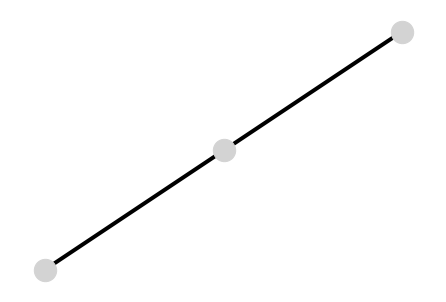

In [14]:
### Clustering 

G1 = G.copy()

for u,v in critical_edge:
    G1.remove_edge(u,v)


S = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]

print(len(S))


link = nx.Graph()
listEdgesBetween = {}
listDemandsBetween = {}



for u,v in critical_edge:
    a = np.infty
    b = np.infty
    for k in range(len(S)) :
        if u in S[k].nodes():
            a = k
        if v in S[k].nodes():
            b = k 
    if a > b :
        a, b = b, a
    if (a, b) not in link.edges():
        link.add_edge(a ,b)
    if ((a,b) in listEdgesBetween):
        listEdgesBetween[(a,b)].append((u,v))
    else :
        listEdgesBetween[(a,b)] = [(u,v)]

# print(link.edges())

nx.draw(link, node_size=500, node_color='lightgrey', width=4)


for (u,v) in criticalDemands : 
    for k in range(len(S)):

        g1 = S[k]
        if u in g1.nodes():
            for j in range(len(S)):
                g2 = S[j]
                if v in g2.nodes():
                    a = k
                    b = j
                    if a > b:
                        a, b = b, a
                    if (a, b) in listDemandsBetween : 
                        listDemandsBetween[(a,b)].append((u,v))
                    else :
                        listDemandsBetween[(a,b)] = [(u,v)]
                if (a, b) not in listDemandsBetween : 
                    listDemandsBetween[(a,b)] = []

# print(listDemandsBetween)
# print(listEdgesBetween)

for (u,v) in link.edges():
    a = u
    b = v 
    if a> b:
        a,b = b,a
    link[a][b]['capa'] = 0
    for (x,y) in listEdgesBetween[(a,b)]:
        link[u][v]['capa'] += G[x][y]['capa']
    # print(link[u][v]['capa'])


# G5 = nx.barbell_graph(3, 0)
# nx.draw(G5, node_size=500, node_color='lightgrey', width=4)


In [15]:
testConfiguration = {}


def priceCut(sameSideNodes) : 
    return nx.cut_size(link, sameSideNodes, weight='capa')

def demandCUt(sameSideNodes):
    demand = 0
    for (u,v) in listDemandsBetween :
        if (u in sameSideNodes and v not in sameSideNodes) or (v in sameSideNodes and u not in sameSideNodes):
            for a,b in listDemandsBetween[(u,v)]:
                if (a>b):
                    a,b =b,a
                demand += K[a][b]['demand']

    return demand

def cut1(A, B):
    link2 = link.copy()
    link2.remove_node(B)
    tableNodesSameSides = [link2.subgraph(c).copy() for c in nx.connected_components(link2)]
    # nx.draw(link2, node_size=500, node_color='lightgrey', width=4)
    for t in tableNodesSameSides :
        if A in t.nodes():
            return t.nodes()

def minCut2():
    cut = np.infty
    cutChoosen = None
    listEgdesChoosen = None
    for k in link.nodes():
        for j in link.neighbors(k):
            if (j > k) or True:
                sameSideNodes = cut1(k, j)
                price = priceCut(sameSideNodes)
                demand = demandCUt(sameSideNodes)
                if (demand > 0 and cut > price/demand):
                    cut = price/demand
                    cutChoosen = (k,j)
                    listEgdesChoosen = edgesChoosen(sameSideNodes)

    return cut, cutChoosen, listEgdesChoosen

def edgesChoosen(cutChoosen):
    listEgdesChoosen = []
    for (u,v)  in listEdgesBetween:
        if (u in cutChoosen and v not in cutChoosen) or (v in cutChoosen and u not in cutChoosen) :
            for a,b in listEdgesBetween[(u,v)] : 
                listEgdesChoosen.append((a,b))
    return listEgdesChoosen



mincut, cutChoosen, listEgdesChoosen = minCut2()

print('')
print('_____ Critical Choosen Edges _____')
criticalChoosenEdges = listEgdesChoosen # We consider the first solution
for (u,v) in criticalChoosenEdges:
    print('link ({0:10s}, {1:10s})\t'.format(site[u],site[v]),'site 1 = '+ str(u)+ ', site 2 = ' + str(v), ', capa = ', G[u][v]['capa'])
# print(criticalChoosenEdges)


# print(sameSideNodes)
print("")
print('mincut = ', mincut)
print('maxflow = ', 1/model.gamma.value)




_____ Critical Choosen Edges _____
link (0         , 77        )	 site 1 = 0, site 2 = 77 , capa =  0.7596198813909236
link (7         , 77        )	 site 1 = 7, site 2 = 77 , capa =  0.9324888225178003
link (18        , 77        )	 site 1 = 18, site 2 = 77 , capa =  0.5103393137144745
link (48        , 77        )	 site 1 = 48, site 2 = 77 , capa =  0.8883554255856618
link (53        , 77        )	 site 1 = 53, site 2 = 77 , capa =  0.7803772433680691

mincut =  2.3110706977577933
maxflow =  2.311070697757793


In [16]:
def getSameSideNodes(node):
    sameSideNodes = [node]
    isAttained = np.zeros(np.max(G.edges) + 1)
    criticalChoosenEdges = []
    queue = collections.deque()
    u = node
    # print(u)
    isAttained[u] = 1
    for n in G.neighbors(u) : 
        if n not in queue :
            if (min(n,u), max(n,u)) not in critical_edge :
                queue.append(n)
            else :
                if (min(n,u), max(n,u)) not in criticalChoosenEdges:
                        criticalChoosenEdges.append((min(n,u), max(n,u)))
                        # print((min(n,u), max(n,u)) in critical_edge)

    # for n in G.neighbors(u):
    #     if n not in queue:
    #         queue.append(n)
    while len(queue) != 0:
        n = queue.popleft()
        isAttained[n] = 1
        # if n in criticalSources : 
        sameSideNodes.append(n)
        for n1 in G.neighbors(n) :
            if (n1 not in queue) and (isAttained[n1] == 0) :
                if (min(n,n1), max(n,n1)) not in critical_edge :
                    queue.append(n1)
                else :
                    if (min(n,n1), max(n,n1)) not in criticalChoosenEdges:
                        criticalChoosenEdges.append((min(n,n1), max(n,n1)))
                        # print((min(n,n1), max(n,n1)) in critical_edge)
    return sameSideNodes, criticalChoosenEdges


def minCut() : 
    min = np.infty
    minCap = 0
    minDemand = 0
    tableSameSideNodes = []
    tableCriticalChoosenEdges =[]
    for node in criticalNodes:
        # table = np.array(tableSameSideNodes).flatten()
        # print(table)
        if node not in [j for l in tableSameSideNodes for j in l]:
            sameSideNodes, criticalChoosenEdges = getSameSideNodes(node)
            demand = 0
            for n in sameSideNodes:
                for (o,d) in criticalDemands :
                    if (n == o and d not in sameSideNodes) or (n == d and o not in sameSideNodes) :
                        demand += K[o][d]['demand']
            capacity = 0
            
            for (u,v) in criticalChoosenEdges:
                capacity += G[u][v]['capa']
            if (demand != 0 and min > capacity/demand):
                min = capacity / demand
                minCap = capacity
                minDemand = demand
                tableSameSideNodes = [sameSideNodes]
                tableCriticalChoosenEdges = [criticalChoosenEdges]
            elif ( demand != 0 and capacity/demand == min):
                tableSameSideNodes.append(sameSideNodes)
                tableCriticalChoosenEdges.append(criticalChoosenEdges)
        
    # print(minDemand)
    # print(minCap)
    return min, tableSameSideNodes, tableCriticalChoosenEdges

mincut,  tableSameSideNodes, tableCriticalChoosenEdges = minCut()

print(tableSameSideNodes)

print('')
print('_____ Critical Choosen Edges _____')
criticalChoosenEdges = tableCriticalChoosenEdges[0] # We consider the first solution
for (u,v) in criticalChoosenEdges:
    print('link ({0:10s}, {1:10s})\t'.format(site[u],site[v]),'site 1 = '+ str(u)+ ', site 2 = ' + str(v), ', capa = ', G[u][v]['capa'])
# print(criticalChoosenEdges)


# print(sameSideNodes)
print("")
print('mincut = ', mincut)
print('maxflow = ', 1/model.gamma.value)

# print("")
print('nombre de solutions optimales trouvées :', len(tableSameSideNodes))

[[77]]

_____ Critical Choosen Edges _____
link (0         , 77        )	 site 1 = 0, site 2 = 77 , capa =  0.7596198813909236
link (7         , 77        )	 site 1 = 7, site 2 = 77 , capa =  0.9324888225178003
link (18        , 77        )	 site 1 = 18, site 2 = 77 , capa =  0.5103393137144745
link (48        , 77        )	 site 1 = 48, site 2 = 77 , capa =  0.8883554255856618
link (53        , 77        )	 site 1 = 53, site 2 = 77 , capa =  0.7803772433680691

mincut =  2.3110706977577933
maxflow =  2.311070697757793
nombre de solutions optimales trouvées : 1


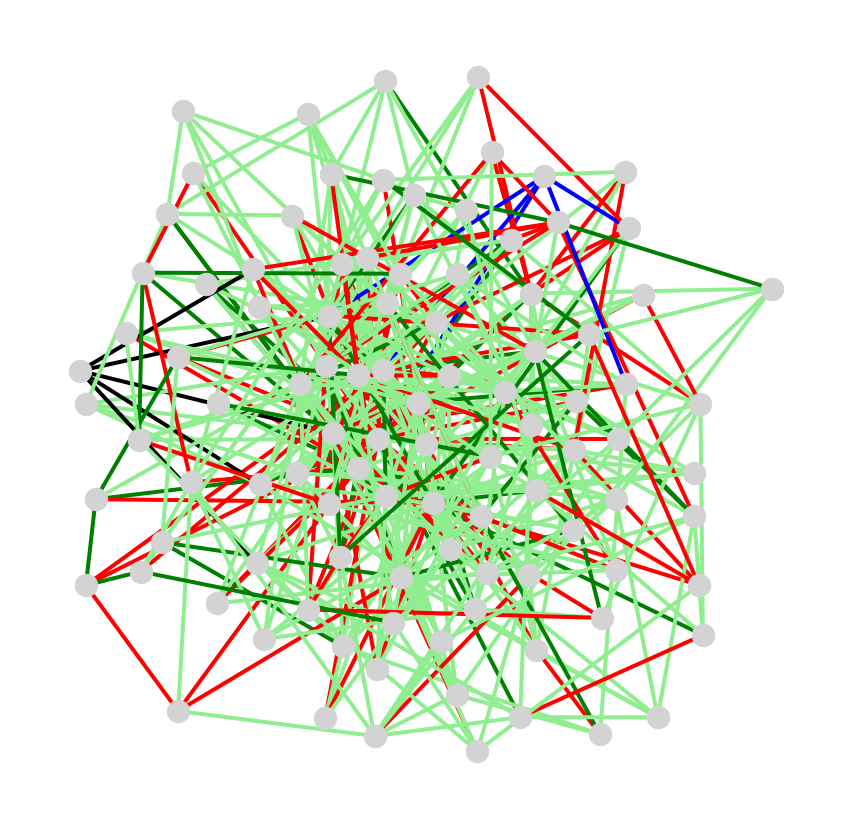

In [18]:
plt.figure(figsize=(15,15));
plt.axis('off')

colors = []
for (u,v) in G.edges():
    if (u,v) in listEgdesChoosen :
        colors.append('blue')
    # elif load[(u,v)] > 100:
    #     colors.append('black')
    elif (u,v) in criticalChoosenEdges :
        colors.append('purple')
    elif (u,v) in critical_edge:
         colors.append('black')
    elif load[(u,v)] > model.gamma.value *100 - epsilon:
        colors.append('red')
    elif load[(u,v)] > 50:
        colors.append('orange')
    elif load[(u,v)] >=25:
        colors.append('green')
    elif load[(u,v)] >=0:
        colors.append('lightgreen')
    else:
        colors.append('lightgrey')


fig = plt.figure(1, figsize=(200, 80), dpi=500)
# nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')
nx.draw(G, node_size=500, node_color='lightgrey', edge_color=colors, width=4)

# nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
# nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')
